# Source Code - Rheological Analysis Toolbox Functions

In [1]:
import os
import openpyxl
import datetime
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go
from ipywidgets import interact, FloatRangeSlider
from prettytable import PrettyTable
from fpdf import FPDF
import re
import scipy
from scipy import stats as stats
from scipy.stats import t
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics



def create_new_workbook(file_name, column_labels):
    """
    Create a new workbook with the given file name and add column_labels as the header.

    Parameters:
        file_name (str): Name of the Excel file to be created.
        column_labels (list): List of strings representing the header labels.

    Returns:
        None
    """
    wb = openpyxl.Workbook()
    ws = wb.active
    ws.append(column_labels)
    wb.save(file_name)

    
def get_unique_file_name(file_name):
    """
    Add a number to the file name to make it unique.

    Parameters:
        file_name (str): Name of the Excel file.

    Returns:
        str: Unique file name with a number appended to it.
    """
    file_name_parts = file_name.split('.')
    base_name = file_name_parts[0]
    extension = file_name_parts[1]
    counter = 1

    unique_file_name = f"{base_name}_{counter}.{extension}"
    
    # Check if the file with the generated unique name already exists
    while os.path.exists(unique_file_name):
        counter += 1
        unique_file_name = f"{base_name}_{counter}.{extension}"

    return unique_file_name


def create_database(file_name, column_labels):
    """
    Create a new database as an empty Excel file with specified headers.

    Parameters:
        file_name (str): Name of the Excel file to be created.
        column_labels (str): Column labels for the database
    
    Returns:
        None
    """
    # Check if the file already exists
    if os.path.exists(file_name):
        # Prompt the user to choose whether to replace or add to the file
        choice = input('A file with this name already exists. Do you want to (R)eplace or (A)dd to the file? ').lower()
        if choice == 'r':
            # Create a new workbook and save it with the same file name
            create_new_workbook(file_name, column_labels)
        elif choice == 'a':
            # Add a number to the file name to make it unique
            unique_file_name = get_unique_file_name(file_name)
            create_new_workbook(unique_file_name, column_labels)
        else:
            print('Invalid choice. Exiting...')
            exit()
    else:
        # Create a new workbook and save it with the file name
        create_new_workbook(file_name, column_labels)

        
        
def get_valid_integer(prompt):
    """
    Prompt the user to input a valid integer.

    Parameters:
        prompt (str): The prompt message for the user.

    Returns:
        int: Valid integer provided by the user.
    """
    while True:
        user_input = input(prompt).strip()
        if not user_input.isdigit():
            print("Invalid input. Please enter a valid integer.")
        else:
            return int(user_input)

        
def get_valid_float(prompt):
    """
    Prompt the user to input a valid float.

    Parameters:
        prompt (str): The prompt message for the user.

    Returns:
        float: Valid float provided by the user.
    """
    while True:
        user_input = input(prompt).strip()
        try:
            number = float(user_input)
            return number
        except ValueError:
            print("Invalid input. Please enter a valid float.")

            
def get_valid_date():
    """
    Prompt the user to input a valid date in the format (DD/MM/YYYY).
    
    Parameters: 
        None.
    
    Returns:
        str: A valid date in the format (DD/MM/YYYY).
    """
    while True:
        date_input = input("Date: (DD/MM/YYYY)").strip()
        try:
            date_obj = datetime.datetime.strptime(date_input, "%d/%m/%Y")
            return date_input
        except ValueError:
            print("Invalid date format. Please enter the date in the format (DD/MM/YYYY).")

            
def get_valid_input(prompt, valid_values=None):
    """
    Prompt the user to input valid data based on the provided prompt and allowed values.

    Parameters:
        prompt (str): The prompt message for the user.
        valid_values (list, optional): A list of valid values (strings) if applicable. Default value: None.

    Returns:
        str: Valid input provided by the user.
    """
    while True:
        user_input = input(prompt).strip().lower()

        if valid_values is not None and user_input not in valid_values:
            valid_values_str = ", ".join(valid_values)
            print(f"Invalid input. Please choose from: {valid_values_str}")
        elif user_input == "":
            print("Empty input not allowed. Please provide a value.")
        else:
            return user_input

        
def sdescription():
    """
    Collect and process sample data from user input.
    
    Parameters:
        None.
    Returns:
        list: A list containing sample information in the following order:
        [Sample ID, Date, Gender, Age, Joint, Condition, Total Volume (mL), Color,
        Transparency, Texture, Blood, Clot, Tissue, Storage in freezer, 
        COVID-19, Vaccinated for COVID-19, COVID-19 now, Number of Tests]
    """
    sdesc = []

    # Prompt the user to input data. Collect sample attributes
    snum = get_valid_integer("Sample's number: ")
    sid = 'S' + str(snum)
    sdesc.append(sid)

    sdate = get_valid_date()
    sdesc.append(sdate)

    sgender = get_valid_input("Gender: (male, female)", valid_values=["male", "female"])
    sdesc.append(sgender)

    sage = get_valid_integer("Age: ")
    sdesc.append(sage)

    sjoint = get_valid_input("Joint: (knee, hip, elbow, wrist, etc.)", 
                             valid_values=["knee", "hip", "elbow", "wrist"])
    sdesc.append(sjoint)

    scon = get_valid_input("Condition: (oa, healthy, meniscal tear, etc.)", 
                           valid_values=["oa", "healthy", "meniscal tear", "patellofemoral pain", "femoral head necrosis", 
                                        "shoulder instability", "acl rupture", "oa broken poly", "nailing hip", 
                                         "patellofemoral cartilage defect"])
    sdesc.append(scon)
    
    svol = get_valid_float("Total volume (mL): '")
    sdesc.append(svol)

    scolor = get_valid_input("Color: (red, orange, yellow, soft yellow, colorless)", 
                             valid_values=["red", "orange", "yellow", "soft yellow", "colorless"])
    sdesc.append(scolor)
    
    strans = get_valid_input("Transparency: (transparent, non-transparent)", 
                              valid_values=["transparent", "non-transparent"])
    sdesc.append(strans)
    
    stexture = get_valid_input("Texture: (viscous, non-viscous)", valid_values=["viscous", "non-viscous"])
    sdesc.append(stexture)
    
    sblood = get_valid_input("Blood: (yes, no)", valid_values=["yes", "no"])
    sdesc.append(sblood)

    sclot = get_valid_input("Clot: (yes, no)", valid_values=["yes", "no"])
    sdesc.append(sclot)

    stissue = get_valid_input("Tissue: (yes, no)", valid_values=["yes", "no"])
    sdesc.append(stissue)
    
    frstorage = get_valid_input("Storage in freezer (-20oC): (yes, no)", valid_values=["yes", "no"])
    sdesc.append(frstorage)

    covid = get_valid_input("COVID-19: (yes, no)", valid_values=["yes", "no"])
    sdesc.append(covid)

    vaccine = get_valid_input("Vaccinated for COVID-19: (yes, no)", valid_values=["yes", "no"])
    sdesc.append(vaccine)

    covid_now = get_valid_input("COVID-19 now: (yes, no)", valid_values=["yes", "no"])
    sdesc.append(covid_now)
    
    tnum = get_valid_integer("Number of test: ")
    sdesc.append(tnum)

    # Print the input data for review
    print('\nInput data:')
    for idx, item in enumerate(sdesc, start=1):
        print(f'{idx}: {item}')

    # Prompt the user to confirm or revise the input data
    choice = input('\nDo you want to (S)ave the data or (R)evise the data? ').lower()
    if choice == 's':
        print('Sample data are saved.')
        return sdesc
    elif choice == 'r':
        # Allow the user to go back and revise any input point
        while True:
            revise = input('\nWhich data point do you want to revise? (1, 2, ... 18) or (E)xit to save: ').lower()
            if revise == 'e':
                break
            elif revise.isdigit() and 1 <= int(revise) <= 18:
                revise_idx = int(revise) - 1
                revised_value = input(f'Revise {sdesc[revise_idx]}: ')
                sdesc[revise_idx] = revised_value
            else:
                print('Invalid choice.')

            # Print the revised input data for review
            print('\nRevised input data:')
            for idx, item in enumerate(sdesc, start=1):
                print(f'{idx}: {item}')

            # Prompt the user to confirm or revise the input data again
            choice = input('\nDo you want to (S)ave the data or (R)evise the data again? ').lower()
            if choice == 's':
                print('Sample data are saved.')
                return sdesc
            elif choice == 'r':
                continue
        # Add a return statement to ensure the function always returns a list
        print('There might be a problem. Check the Excel Workbook.')
        return sdesc
    else:
        # Add a return statement to ensure the function always returns a list
        print('There might be a problem. Check the Excel Workbook.')
        exit()

        
def tdescription(my_list):
    """
    Collect and process test data from user input.
    
    Parameters:
        list: A list containing sample information in the following order:
        [Sample ID, Date, Gender, Age, Joint, Condition, Total Volume (mL), 
        Color, Transparency, Texture, Blood, Clot, Tissue, Storage in freezer, 
        COVID-19, Vaccinated for COVID-19, COVID-19 now, Number of Tests]
        
    Returns:
        list: A list containing sample information in the following order:
        [Test Type, Temperature (oC), Tissue in Test, Bubbles before Test, Bubbles after Test,]
    """
    stissue = my_list[12]
    tnum = int(my_list[17])
    
    tdesc = []
    
    for i in range(tnum):
        # Prompt the user to input data. Collect test attributes
        ttype = get_valid_input("Test type: (time sweep, frequency sweep, flow step, strain sweep)", 
                                  valid_values=["time sweep", "frequency sweep", "flow step", "strain sweep"])

        ttemp = get_valid_input("Temperature (oC): (25, 37)", valid_values=["25", "37"])

        if stissue == 'yes':
            ttissue = get_valid_input("Tissue in test: (yes, no)", valid_values=["yes", "no"])
        else:
            ttissue = 'no'

        btbubbles = get_valid_input("Bubbles before test: (yes, no)", valid_values=["yes", "no"])

        atbubbles = get_valid_input("Bubbles after test: (yes, no)", valid_values=["yes", "no"])
        
        test_info = [ttype, ttemp, ttissue, btbubbles, atbubbles]
        
        # Print the input data for review
        print('\nInput data:')
        for idx, item in enumerate(test_info, start=1):
            print(f'{idx}: {item}')

        # Prompt the user to confirm or revise the input data
        choice = input('\nDo you want to (S)ave the data or (R)evise the data? ').lower()
        if choice == 's':
            print('Test data are saved.')
            tdesc.append(test_info)
            
        elif choice == 'r':
            # Allow the user to go back and revise any input point
            while True:
                revise = input('\nWhich data point do you want to revise? (1, 2, ... 5) or (E)xit to save: ').lower()
                if revise == 'e':
                    break
                elif revise.isdigit() and 1 <= int(revise) <= 5:
                    revise_idx = int(revise) - 1
                    revised_value = input(f'Revise {test_info[revise_idx]}: ')
                    test_info[revise_idx] = revised_value
                else:
                    print('Invalid choice.')

                # Print the revised input data for review
                print('\nRevised input data:')
                for idx, item in enumerate(test_info, start=1):
                    print(f'{idx}: {item}')

                # Prompt the user to confirm or revise the input data again
                choice = input('\nDo you want to (S)ave the data or (R)evise the data again? ').lower()
                if choice == 's':
                    print('Test data are saved.')
                    tdesc.append(test_info)
                    break
                elif choice == 'r':
                    continue
                else:
                    # Add a return statement to ensure the function always returns a list
                    print('There might be a problem. Check the Excel Workbook.')
                    break
        else:
            # Add a return statement to ensure the function always returns a list
            print('There might be a problem. Check the Excel Workbook.')
            exit()
    return tdesc 
  
    
def append_sample_to_database(file_name="Database.xlsx"):
    """
    Append new sample data to an existing Excel database.

    Parameters:
        file_name (str, optional): Name of the Excel file to be updated. Default value: "Database.xlsx".

    Returns:
        None
    """
    sample_data = sdescription()
    test_data = tdescription(sample_data)

    # Load the existing Excel file
    wb = openpyxl.load_workbook(file_name)
    sheet = wb.active

    # Find the next empty row in the Excel sheet
    next_row = sheet.max_row + 1

    # Append the sample data to the next empty row
    for col, item in enumerate(sample_data, start=1):
        sheet.cell(row=next_row, column=col).value = item

    # Store test details in separate rows
    tnum = len(test_data)
    test_start_row = next_row

    for i in range(tnum):
        # Write the test data to the Excel workbook
        row_values = test_data[i]
        for col, item in enumerate(row_values, start=19):  # Starting from column 'S'
            sheet.cell(row=next_row, column=col).value = item
        next_row += 1

    # Fill the remaining columns (A to S) with copies of the sample_data for each row of test_data
    for col, item in enumerate(sample_data, start=1):
        for row in range(test_start_row + 1, test_start_row + tnum):
            sheet.cell(row=row, column=col).value = item
    
    # Save the changes back to the Excel file
    wb.save(file_name)
    
    print('Your data are saved in the Excel Workbook.')

    
    
def plot_time_sweep_data(df_ts):
    """
    Plot the time sweep data as a scatter plot.

    Parameters:
        df (DataFrame): The input DataFrame containing the time sweep data.
    
    Returns:
        None
    """
    # Create the scatter plot
    @interact(ymin=FloatRangeSlider(value=[1e-4, 1e2], min=1e-4, max=1e2, step=1e-4,
                                    description='y-axis limits:', readout_format='.1e'),)
    def plot_interactive(ymin):
        sns.set_theme(style="darkgrid")
        custom_palette = sns.color_palette("deep")
        custom_palette[1] = "red"
        sns.set_palette(custom_palette)
        ax = sns.scatterplot(x='time (min)', y='G\' (Pa)', data=df_ts, alpha=0.7)
        sns.scatterplot(x='time (min)', y='G\'\' (Pa)', data=df_ts, alpha=0.7)
        ax.set_ylim(ymin=ymin[0], ymax=ymin[1])
        ax.set_yscale('log')
        plt.grid(True, which="both", ls="-", c='white')
        plt.xlabel("time (min)")
        plt.ylabel("G', G'' (Pa)")
        legend_artists = [plt.Line2D([0], [0], marker='o', lw=0),
                          plt.Line2D([0], [0], marker='o', lw=0, color='red')]
        legend_labels = ['G\'', 'G\'\'']
        ax.legend(legend_artists, legend_labels, bbox_to_anchor=(1.1, 1), loc='upper left')
        plt.show()

        
def time_sweep_data_analysis(df):
    """
    Perform analysis on time sweep data for Osteoarthritis medical device.

    Parameters:
        df (DataFrame): The input DataFrame containing the time sweep data.

    Returns:
        mean_values (numpy.array): G' and G'' (Pa) at 3.142 rad/s from time sweep test.
        std_values (numpy.array): G' and G'' standard deviations from time sweep test.
    """    
    # Select the specific columns for the time sweep
    columns_ts = ['time (min)', 'G\' (Pa)', 'G\'\' (Pa)']
    df_ts = df[columns_ts]
    
    # Plot
    plot_time_sweep_data(df_ts)

    # Determine the last time value
    last_time_value = df_ts['time (min)'].iloc[-1]

    # Prompt the user for start and finish time points
    t_start = float(input(f'Give a time start point (0.1, 0.2 ... {last_time_value}): '))
    t_finish = float(input(f'Give a time finish point (0.1, 0.2 ... {last_time_value}): '))

    # Define the list of values within the selected time interval
    time_interval = df_ts[(df_ts['time (min)'] >= t_start) & (df_ts['time (min)'] <= t_finish)]

    # Calculate the mean and standard deviation of the selected values
    mean_values = np.mean(time_interval, axis=0)[-2:]
    std_values = np.std(time_interval, axis=0)[-2:]

    # Create a table with two columns
    table = PrettyTable(['Variable', 'Value'])

    # Add the mean and standard deviation values to the table
    table.add_row(['Mean', mean_values.to_string()])
    table.add_row(['Standard deviation', std_values.to_string()])

    # Print the table
    print(table)

    # Return the mean and standard deviation values as a DataFrame
    result_df = pd.DataFrame({'Variable': ['Mean', 'Standard deviation'],
                              'Value': [mean_values, std_values]})

    return mean_values, std_values


def plot_frequency_sweep_data(df_fs, frequency_interval):
    """
    Plot the frequency sweep data as a scatter plot.

    Parameters:
        df (DataFrame): The input DataFrame containing the frequency sweep data.
        frequency_interval (DataFrame): A subset of the df_fs DataFrame, representing the data within a selected time interval.
    
    Returns:
        None
    """   
    # Create the scatter plot
    @interact(ymin_primary=FloatRangeSlider(value=[1e-4, 1e2], min=1e-4, max=1e2, step=1e-4, 
                                            description='Primary y-axis limits:', readout_format='.1e'),
              ymin_secondary=FloatRangeSlider(value=[1e-4, 1e2], min=1e-4, max=1e2, step=1e-4, 
                                              description='Secondary y-axis limits:', readout_format='.1e'))
    def show_graph(ymin_primary, ymin_secondary):
        sns.set_theme(style="darkgrid")
        custom_palette = sns.color_palette("deep")
        custom_palette[1] = "red"
        sns.set_palette(custom_palette)
        ax = sns.scatterplot(x='ang. Frequency (rad/s)',y='G\' (Pa).1', data=frequency_interval, alpha=0.7)
        sns.scatterplot(x='ang. Frequency (rad/s)',y='G\'\' (Pa).1', data=frequency_interval, alpha=0.7)
        ax.set_ylim(ymin=ymin_primary[0], ymax=ymin_primary[1])
        ax.set_yscale('log') 
        ax.set_xscale('log')
        plt.xlabel("angular frequency (rad/s)")
        plt.ylabel("G', G'' (Pa)")
        ax2 = ax.twinx()
        sns.scatterplot(x='ang. Frequency (rad/s)',y='|n*| (Pa.s)', data=frequency_interval, color='green', 
                        ax=ax2, alpha=0.7)
        ax2.set_ylim(ymin=ymin_secondary[0], ymax=ymin_secondary[1])
        ax2.set_yscale('log')
        ax.minorticks_on()
        ax.grid(True, which='both')
        plt.ylabel("|n*| (Pa.s)")
        legend_artists = [plt.Line2D([0], [0], marker='o', lw=0),
                          plt.Line2D([0], [0], marker='o', color='red', lw=0),
                          plt.Line2D([0], [0], marker='o', color='green', lw=0)]
        legend_labels = ['G\'', 'G\'\'', '|n*|']
        ax.legend(legend_artists, legend_labels,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.show()

    
def frequency_sweep_data_analysis(df):
    """
    Perform analysis on frequency sweep data for Osteoarthritis medical device.

    Parameters:
        df (DataFrame): The input DataFrame containing the frequency sweep data.

    Returns:
        G_pf (float): G' (Pa) at 3.142 rad/s from frequency sweep test.
        G_dpf (float): G'' (Pa) at 3.142 rad/s from frequency sweep test.
        G_pf1 (float): G' (Pa) at 0.68 rad/s from frequency sweep test.
        G_dpf1 (float): G'' (Pa) at 0.68 rad/s from frequency sweep test.
        G_pf2 (float): G' (Pa) at 14.58 rad/s from frequency sweep test.
        G_dpf2 (float): G'' (Pa) at 14.58 rad/s from frequency sweep test.
        eta_star (float): Complex viscosity (Pa.s) at 3.142 rad/s from frequency sweep test.
        crossover_point (float): Cross-over point from frequency sweep test.
    """
    # Select the specific columns for the frequency sweep
    columns_fs = ['ang. Frequency (rad/s)', 'G\' (Pa).1', 'G\'\' (Pa).1', '|n*| (Pa.s)', 'delta (degrees)']
    df_fs = df[columns_fs]
    
    # Delete NaN values
    df_fs = df_fs.dropna(how='any')
    
    # Define the list of values within the selected delta range
    frequency_interval = df_fs[df_fs['delta (degrees)'] < 90]
    delta_df = df_fs[df_fs['delta (degrees)'] < 150]
    
    # Plot
    plot_frequency_sweep_data(df_fs, frequency_interval)
    
    # Get the frequency sweep data at specific indices
    G_pf = frequency_interval.loc[3, 'G\' (Pa).1']
    G_dpf = frequency_interval.loc[3, 'G\'\' (Pa).1']
    G_pf1 = frequency_interval.loc[1, 'G\' (Pa).1']
    G_dpf1 = frequency_interval.loc[1, 'G\'\' (Pa).1']
    
    # Get the frequency sweep data at specific indices if delta <= 90
    delta = delta_df.loc[5, 'delta (degrees)']
    if delta <= 90:
        G_pf2 = frequency_interval.loc[5, 'G\' (Pa).1']
        G_dpf2 = frequency_interval.loc[5, 'G\'\' (Pa).1']
    else:
        G_pf2 = np.nan
        G_dpf2 = np.nan
    
    # Get the viscosity |n*| at 3.142 rad/s
    eta_star = frequency_interval.loc[3, '|n*| (Pa.s)']
    
    # Check which value is bigger in the first row (G' or G'')
    if frequency_interval.iloc[0]['G\' (Pa).1'] > frequency_interval.iloc[0]['G\'\' (Pa).1']:
        bigger_col = 'G\' (Pa).1'
        smaller_col = 'G\'\' (Pa).1'
    else:
        bigger_col = 'G\'\' (Pa).1'
        smaller_col = 'G\' (Pa).1'

    # Initialize variables to store the closest difference
    closest_diff = float('inf')
    closest_diff_index = None

    # Find the crossover point
    for index, row in frequency_interval.iterrows():
        # Check if the bigger value crossed the smaller value
        if row[bigger_col] < row[smaller_col]:
            # Calculate the difference between the values
            diff = abs(row[bigger_col] - row[smaller_col])
            # Check if this difference is closer than the previous closest difference
            if diff < closest_diff:
                closest_diff = diff
                closest_diff_index = index

    # Check if a crossover point was found
    if closest_diff_index is not None:
        crossover_point = frequency_interval.loc[closest_diff_index, 'ang. Frequency (rad/s)']
        print(f"Crossover point at: {crossover_point}")
    else:
        crossover_point = None
        print("No crossover point was found.")
    
    print()
    return G_pf, G_dpf, G_pf1, G_dpf1, G_pf2, G_dpf2, eta_star, crossover_point


def calculate_cross_model_equation(s, eta_0, eta_inf, K, n):
    """
    Calculate the cross model equation given the parameters.

    Parameters:
        s (numpy.array): The array of shear rates.
        eta_0 (float): The zero-rate viscosity (Pa.s).
        eta_inf (float): The infinite-rate viscosity (Pa.s).
        K (float): The consistency (s).
        n (float): The rate index (-).

    Returns:
        numpy.array: The calculated viscosities using the cross model equation.
    """
    return (eta_0 - eta_inf) / (1 + (s * K) ** n) + eta_inf


def plot_flow_step_data(df_step, s_cross, n_cross, ymin_primary):
    """
    Plot the flow step data as a scatter plot.

    Parameters:
        df_step (DataFrame): The input DataFrame containing the flow step data.
        s_cross (numpy.array): The array of shear rates for cross model calculation.
        n_cross (numpy.array): The calculated viscosities using the cross model equation.
        ymin_primary (tuple): The range for the primary y-axis.
    """
    sns.set_theme(style="darkgrid")
    custom_palette = sns.color_palette("deep")
    custom_palette[1] = "red"
    sns.set_palette(custom_palette)
    ax = sns.lineplot(x=s_cross, y=n_cross, alpha=0.7)
    sns.scatterplot(x='shear rate (1/s)', y='viscosity (Pa.s)', data=df_step, color="red", alpha=0.7)
    ax.set_xlim(xmin=1e-4, xmax=1e6)
    ax.set_ylim(ymin=ymin_primary[0], ymax=ymin_primary[1])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both')
    plt.xlabel("shear rate (1/s)")
    plt.ylabel("viscosity (Pa.s)")
    legend_artists = [plt.Line2D([0], [0], marker='o', lw=0),
                      plt.Line2D([0], [0], color='red', lw=4)]
    legend_labels = ['Cross model viscosity', 'Flow step viscosity']
    ax.legend(legend_artists, legend_labels, bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.show()

    
def flow_step_data_analysis(df):
    """
    Perform analysis on flow step data for Osteoarthritis medical device.

    Parameters:
        df (DataFrame): The input DataFrame containing the flow step data.

    Returns:
        eta_0 (float): Zero rate viscosity (Pa.s) from cross model.
        eta_inf (float): Infinite rate viscosity (Pa.s) from cross model.
        K (float): Consistency (Pa.s) from cross model.
        n (float): Exponent (-) from cross model.
        error (float): Deviation of the model (-) from cross model.
        eta (float): Viscosity (Pa.s) at 3.162 1/s from flow step measurement.
    """
    # Select the specific columns for the flow step
    columns_step = ['shear rate (1/s)', 'viscosity (Pa.s)']
    df_step = df[columns_step]
    
    # Delete NaN values
    df_step = df_step.dropna(how='any')

    # Extract the data for cross model calculation
    s = df_step['shear rate (1/s)']
    eta_0 = df.at[0, 'zero-rate viscosity (Pa.s)']
    eta_inf = df.at[0, 'infinite-rate viscosity (Pa.s)']
    K = df.at[0, 'consistency (s)']
    n = df.at[0, 'rate index (-)']
    eta = df_step.at[3, 'viscosity (Pa.s)']

    # Calculate the cross model equation
    s_start = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05])
    s_end = np.array([5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000])
    s_cross = np.concatenate((s_start, s, s_end))
    n_cross = calculate_cross_model_equation(s_cross, eta_0, eta_inf, K, n)

    # Create the interactive plot
    @interact(ymin_primary=FloatRangeSlider(value=[1e-4, 1e2], min=1e-4, max=1e2, step=1e-4,
                                            description='y-axis limits:', readout_format='.1e'),)
    def plot_interactive(ymin_primary):
        plot_flow_step_data(df_step, s_cross, n_cross, ymin_primary)

    # Return the calculated values as a dictionary
    return eta_0, eta_inf, K, n, df.at[0, 'standard error'], eta


def plot_cox_merz_data(df_cox, ymin_primary):
    """
    Plot the Cox-Merz data as a scatter plot.

    Parameters:
        df_cox (DataFrame): The input DataFrame containing the Cox-Merz data.
        ymin_primary (tuple): The range for the primary y-axis.
    
    Returns:
        None
    """
    sns.set_theme(style="darkgrid")
    custom_palette = sns.color_palette("deep")
    custom_palette[1] = "green"
    sns.set_palette(custom_palette)
    ax = sns.scatterplot(x='shear rate (1/s)', y='viscosity (Pa.s)', data=df_cox, alpha=0.7)
    sns.scatterplot(x='ang. Frequency (rad/s)', y='|n*| (Pa.s)', data=df_cox, alpha=0.7)
    ax.set_ylim(ymin=ymin_primary[0], ymax=ymin_primary[1])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both')
    plt.xlabel("shear rate (1/s), angular frequency (rad/s)")
    plt.ylabel("viscosity (Pa.s), |n*| (Pa.s)")
    legend_artists = [plt.Line2D([0], [0], marker='o', lw=0),
                      plt.Line2D([0], [0], marker='o', color='green', lw=0)]
    legend_labels = ['viscosity', '|n*|']
    ax.legend(legend_artists, legend_labels, bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.show()

    
def cox_merz_rule(df):
    """
    Perform Cox-Merz analysis for Osteoarthritis medical device.

    Parameters:
        df_cox (DataFrame): The input DataFrame containing the Cox-Merz data.

    Returns:
        eta (float): Viscosity (Pa.s) at 3.162 1/s from flow step test.
        eta_star (float): Complex viscosity (Pa.s) at 3.142 rad/s from frequency test.
    """
    # Select the specific columns for the cox merz
    columns_cox = ['shear rate (1/s)', 'viscosity (Pa.s)', 'ang. Frequency (rad/s)', '|n*| (Pa.s)']
    df_cox = df[columns_cox]
    # Delete NaN values
    df_cox = df_cox.dropna(how='any')

    # Create the interactive plot
    @interact(ymin_primary=FloatRangeSlider(value=[1e-4, 1e2], min=1e-4, max=1e2, step=1e-4,
                                            description='y-axis limits:', readout_format='.1e'),)
    def plot_interactive(ymin_primary):
        plot_cox_merz_data(df_cox, ymin_primary)

    # Get the viscosities at specific shear rate and angular frequency
    eta = df_cox.at[3, 'viscosity (Pa.s)']
    eta_star = df_cox.at[3, '|n*| (Pa.s)']

    # Create a table with three columns
    table = PrettyTable(['Experiment', 'Variable', 'Value'])

    # Add the mean and standard deviation values to the table
    table.add_row(['Flow step', 'viscosity (Pa.s)', eta])
    table.add_row(['Frequency sweep', '|n*| (Pa.s)', eta_star])

    # Print the table
    print(table)

    # Return the calculated values as a dictionary
    return eta, eta_star


def sample_analysis(sid, df_ed="Experimental_Data.xlsx"):
    """
    Perform sample analysis and generate a report.

    Parameters:
        sid (str): The sample ID.
        df_ed (DataFrame, optional): The input DataFrame containing the experimental data. Default value: "Experimental_Data.xlsx".

    Returns:
        dict: A dictionary containing the analysis results.
    """    
    df_ed = pd.read_excel(df_ed, sid)
    analysis_results = {}
    
    # Check if the time sweep data is present in the "df_ed" dataframe
    if "time (min)" in df_ed.columns:
        mean_values, std_values = time_sweep_data_analysis(df_ed)
        analysis_results['time_sweep'] = {
            'mean_values': mean_values,
            'std_values': std_values
        }
    else:
        print("There are no time sweep data")

    # Check if the frequency sweep data is present in the "df_ed" dataframe
    if "ang. Frequency (rad/s)" in df_ed.columns:
        G_pf, G_dpf, G_pf1, G_dpf1, G_pf2, G_dpf2, eta_star, crossover_point = frequency_sweep_data_analysis(df_ed)
        analysis_results['frequency_sweep'] = {
            'G_pf': G_pf,
            'G_dpf': G_dpf,
            'G_pf1': G_pf1,
            'G_dpf1': G_dpf1,
            'G_pf2': G_pf2,
            'G_dpf2': G_dpf2,
            'eta_star': eta_star,
            'crossover_point': crossover_point
        }
    else:
        print("There are no frequency sweep data")

    # Check if the flow step data is present in the "df_ed" dataframe
    if "shear rate (1/s)" in df_ed.columns:
        eta_0, eta_inf, K, n, error, eta = flow_step_data_analysis(df_ed)
        analysis_results['flow_step'] = {
        'eta_0': eta_0,
        'eta_inf': eta_inf,
        'K': K,
        'n': n,
        'error': error,
        'eta': eta
        }
    else:
        print("There are no flow step data")

    # Check if the cox merz data is present in the "df_ed" dataframe
    if "ang. Frequency (rad/s)" in df_ed.columns and "shear rate (1/s)" in df_ed.columns:
        eta, eta_star = cox_merz_rule(df_ed)
        analysis_results['cox_merz'] = {
        'eta': eta,
        'eta_star': eta_star
        }
    else:
        print("There are no cox merz data")
        
    return analysis_results



def append_samples_to_final_database(start_row_n, database_file="Database.xlsx", experiment_data_file="Experimental_Data.xlsx", analysis_data_file="Statistical_Analysis_Database.xlsx"):
    """
    Load the database file, process the data, and store the analysis results.

    Parameters:
        start_row_n (int): The sample number from which to start the analysis.
        database_file (str, optional): The filename of the database Excel file. Default value: "Database.xlsx".
        experiment_data_file (str, optional): The folder path containing the experiment data files. Default value: "Experimental_Data.xlsx".
        analysis_data_file (str, optional): Name of the Excel file to be updated. Default value: "Statistical_Analysis_Database.xlsx".

    Returns:
        DataFrame: The updated database with the analysis results.
    """
    start_row_n = str(start_row_n)
    
    # Load the database file into a DataFrame
    database = pd.read_excel(database_file)

    # Set the "ID" column as the index of the dataframe
    database = database.set_index("ID")

    # Remove any duplicates in the "ID" index, keeping the first occurrence
    database = database[~database.index.duplicated(keep='first')]

    # Remove the columns you don't need
    to_drop = ["Date", "Total Volume (mL)", "Color", "Transparency", "Texture", "Number of Tests", "Test Type", "Temperature (oC)", "Bubbles before Test", "Bubbles after Test"]
    database = database.drop(columns=to_drop)

    # Show the resulting dataframe
    print(database)

    # Start row
    start_row = 'S' + start_row_n
    print(f"The appending starts from the {start_row} sample.")

    # Slice the DataFrame to select only the rows after the start row
    sub_database = database.loc[start_row:].copy()
    
    # Loop through each ID (row) in the dataframe
    for index, row in sub_database.iterrows():
        sid = index  # Set ID as sid
        print(f'Sample ID: {sid}')
        
        analysis_results = sample_analysis(sid, experiment_data_file)

        if "time_sweep_mean" in analysis_results:
            time_results = analysis_results["time_sweep"]
            sub_database.loc[sid, "Time Sweep G' average (Pa)"] = time_results["time_sweep_mean"][0]
            sub_database.loc[sid, "Time Sweep G'' average (Pa)"] = time_results["time_sweep_mean"][1]
            sub_database.loc[sid, "Time Sweep G' standard deviation (-)"] = time_results["time_sweep_std"][0]
            sub_database.loc[sid, "Time Sweep G'' standard deviation (-)"] = time_results["time_sweep_std"][1]

        if "frequency_sweep" in analysis_results:
            freq_results = analysis_results["frequency_sweep"]
            sub_database.loc[sid, "Frequency Sweep G' at 0.68 rad/s (Pa)"] = freq_results["G_pf1"]
            sub_database.loc[sid, "Frequency Sweep G'' at 0.68 rad/s (Pa)"] = freq_results["G_dpf1"]
            sub_database.loc[sid, "Frequency Sweep G' at 3.142 rad/s (Pa)"] = freq_results["G_pf"]
            sub_database.loc[sid, "Frequency Sweep G'' at 3.142 rad/s (Pa)"] = freq_results["G_dpf"]
            sub_database.loc[sid, "Frequency Sweep G' at 14.58 rad/s (Pa)"] = freq_results["G_pf2"]
            sub_database.loc[sid, "Frequency Sweep G'' at 14.58 rad/s (Pa)"] = freq_results["G_dpf2"]
            sub_database.loc[sid, "Cross Over Point (rad/s)"] = freq_results["crossover_point"]
            sub_database.loc[sid, "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)"] = freq_results["eta_star"]

        if "flow_step" in analysis_results:
            flow_results = analysis_results["flow_step"]
            sub_database.loc[sid, "Zero-rate Viscosity (Pa.s)"] = flow_results["eta_0"]
            sub_database.loc[sid, "Infinite-rate Viscosity (Pa.s)"] = flow_results["eta_inf"]
            sub_database.loc[sid, "Consistency (s)"] = flow_results["K"]
            sub_database.loc[sid, "Rate Index (-)"] = flow_results["n"]
            sub_database.loc[sid, "Standard Error (-)"] = flow_results["error"]
            sub_database.loc[sid, "Flow Step Viscosity at 3.162 1/s (Pa.s)"] = flow_results["eta"]

        print(sub_database.loc[sid])

    print(sub_database)
    
    # Reset the index to move the "ID" column back as a regular column
    sub_database.reset_index(inplace=True)
    
    existing_database = pd.read_excel(analysis_data_file)
    result = pd.concat([existing_database, sub_database], ignore_index=True)
    result = result.reindex()

    result.to_excel(analysis_data_file, index=False)

    return result



def create_sample_report(snum, database_file="Database.xlsx", analysis_data_file="Statistical_Analysis_Database.xlsx", txt_file="report_template.txt", t_start=0.5, t_finish=5):
    """
    Load and process the sample's data. Create the technical report with the results.

    Parameters:
        snum (int): The sample ID number.
        database_file (str, optional): The filename of the database Excel file. Default value: "Database.xlsx".
        analysis_data_file (str, optional): The filename of the Excel file containing the statistical analysis data. The default value is "Statistical_Analysis_Database.xlsx".
        txt_file (str, optional): The filename of the text file serving as a report template. Default value: "report_template.txt".
        t_start (float, optional): The starting time in minutes for data analysis in the Time Sweep test. Default value: 0.5.
        t_finish (float, optional): The ending time in minutes for data analysis in the Time Sweep test. Default value: 5.
    
    Returns:
        None.
    """
    sid = 'S' + str(snum)
    
    # Load the database files into DataFrames
    database = pd.read_excel(database_file)
    database = database.set_index("ID")
    database = database[~database.index.duplicated(keep='first')]
    statistical_database = pd.read_excel(analysis_data_file)
    statistical_database = statistical_database.set_index("ID")

    # Data from database_file
    selected_sample = database.loc[sid]
    sdate = selected_sample['Date']
    sgender = selected_sample['Gender']
    sage = selected_sample['Age']
    sjoint = selected_sample['Joint']
    scon = selected_sample['Condition']
    svol = selected_sample['Total Volume (mL)']
    scolor = selected_sample['Color']
    strans = selected_sample['Transparency']
    stexture = selected_sample['Texture']
    sblood = selected_sample['Blood']
    sclot = selected_sample['Clot']
    stissue = selected_sample['Tissue']
    frstorage = selected_sample['Storage in freezer']
    covid = selected_sample['COVID 19']
    vaccine = selected_sample['Vaccined COVID 19']
    covid_now = selected_sample['COVID 19 now']
    
    # Data from analysis_data_file
    selected_sample2 = statistical_database.loc[sid]
    G_pt = selected_sample2["Time Sweep G' average (Pa)"]
    G_dpt = selected_sample2["Time Sweep G'' average (Pa)"]
    G_pstd = selected_sample2["Time Sweep G' standard deviation (-)"]
    G_dpstd = selected_sample2["Time Sweep G'' standard deviation (-)"]
    G_pf1 = selected_sample2["Frequency Sweep G' at 0.68 rad/s (Pa)"]
    G_dpf1 = selected_sample2["Frequency Sweep G'' at 0.68 rad/s (Pa)"]
    G_pf = selected_sample2["Frequency Sweep G' at 3.142 rad/s (Pa)"]
    G_dpf = selected_sample2["Frequency Sweep G'' at 3.142 rad/s (Pa)"]
    G_pf2 = selected_sample2["Frequency Sweep G' at 14.58 rad/s (Pa)"]
    G_dpf2 = selected_sample2["Frequency Sweep G'' at 14.58 rad/s (Pa)"]
    crossover_point = selected_sample2["Cross Over Point (rad/s)"]
    eta_star = selected_sample2["Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)"]
    eta_0 = selected_sample2["Zero-rate Viscosity (Pa.s)"]
    eta_inf = selected_sample2["Infinite-rate Viscosity (Pa.s)"]
    K = selected_sample2["Consistency (s)"]
    n = selected_sample2["Rate Index (-)"]
    error = selected_sample2["Standard Error (-)"]
    eta = selected_sample2["Flow Step Viscosity at 3.162 1/s (Pa.s)"]

    # Data from report_template.txt
    variables = {}
    with open(txt_file, "r") as file:
        for line in file:
            # Use regular expression to find lines with variables and values
            match = re.match(r"^\s*([\w_]+)\s*=\s*(.+)\s*$", line)
            if match:
                variable_name, value = match.groups()
                variables[variable_name] = value
    
    # Format information
    font = variables[list(variables.keys())[0]]

    # Basic information
    writer_name = variables[list(variables.keys())[1]]
    sup_name = variables[list(variables.keys())[2]]
    today = datetime.date.today()
    today_date = today.strftime("%d/%m/%Y")
    today_date_str = today_date.replace("/", "_")
    filename = f"{sid}_Report_{today_date_str}.pdf"
    header = f"HSF_{sid}_Report"
    title = f"Report - HSF_{sid}"
    
    # Images
    im1 = variables[list(variables.keys())[3]]
    im2 = variables[list(variables.keys())[4]]
    im3 = variables[list(variables.keys())[5]]
    im4 = variables[list(variables.keys())[6]]
    im5 = variables[list(variables.keys())[7]]
    im6 = variables[list(variables.keys())[8]]
    im7 = variables[list(variables.keys())[9]]
    im8 = variables[list(variables.keys())[10]]
    im9 = variables[list(variables.keys())[11]]
    im10 = variables[list(variables.keys())[12]]
    im11 = variables[list(variables.keys())[13]]
    im12 = variables[list(variables.keys())[14]]

    # Other information
    test_temp = variables[list(variables.keys())[15]]
    
    # Text
    time_text = variables[list(variables.keys())[16]]
    freq_text = variables[list(variables.keys())[17]]
    flow_text = variables[list(variables.keys())[18]]
    cox_text = variables[list(variables.keys())[19]]
    results_text = variables[list(variables.keys())[20]]
    
    # Control Loops
    if sblood == "yes":
        if sclot == "yes":
            if stissue == "yes":
                bct = "with blood, clot and tissue"
            else:
                bct = "with blood and clot, but without tissue"
        else:
            if stissue == "yes":
                bct = "with blood and tissue, but without clot"
            else:
                bct = "with blood, but without tissue or clot"
    else:
        if stissue == "yes":
            bct = "without blood, but with tissue"
        else:
            bct = "without blood, clot and tissue"

    # Header and footer
    class PDF(FPDF):
        def __init__(self):
            super().__init__()
        def header(self):
            if self.page_no() != 1:
                self.set_font(font, '', 10)
                self.set_text_color(128, 128, 128) # set color to grey
                self.cell(0, 10, f"© Biomedical Engineering Lab | Chemical Engineering AUTh - {header}", 0, 1, 'L')
        def footer(self):
            self.set_y(-15)
            self.set_font(font, '', 10)
            self.set_text_color(128, 128, 128) # set color to grey
            self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    # Report
    pdf = PDF()
    pdf.add_page()

    # Title section
    pdf.set_font(font, 'B', 16)
    pdf.cell(w=0, h=10, txt=title, ln=1, align='C')
    pdf.ln(5)

    # Report's information
    pdf.set_font(font, '', 12)
    pdf.cell(w=0, h=10, txt=f"Author: {writer_name}", ln=1)
    pdf.set_font(font, '', 12)
    pdf.cell(w=0, h=10, txt=f"Supervisor: {sup_name}", ln=1)
    pdf.set_font(font, '', 12)
    pdf.cell(w=0, h=10, txt=f"Date: {today_date}", ln=1)
    pdf.ln(10)


    # Sample's information
    pdf.set_font(font, 'B', 12)
    pdf.cell(w=0, h=10, txt=f"1. Sample's Information", ln=1)
    pdf.set_font(font, '', 12)
    tnum = 1
    pdf.set_font(font, 'I', 10)
    pdf.multi_cell(w=0, h=10, txt=f"Table {tnum}: Sample's information summary.")
    pdf.set_font(font, '', 12)
    data = [['Sampling date', sdate],
            ['Test date', today_date],
            ['Stored in freezer', frstorage],
            ['COVID 19 in general', covid],
            ['COVID 19 vaccination', vaccine],
            ['COVID 19 when tested', covid_now]]
    # Set width and height of cells
    cell_width = 60
    cell_height = 6
    # Loop through data and add cells to the table
    for row in data:
        for item in row:
            pdf.cell(cell_width, cell_height, str(item), border=1)
        pdf.ln()
    pdf.ln(10)


    # Sample's description
    pdf.set_font(font, 'B', 12)
    pdf.cell(w=0, h=10, txt=f"2. Sample's Description", ln=1)
    pdf.set_font(font, '', 12)
    pdf.multi_cell(w=0, h=10, txt=f"The sample had a total volume of approximately {svol}" + \
                   f" ml. It was {scolor} in color, {strans}, {stexture}, {bct}.", border=0, align='J')

    pdf.image(im1, x=pdf.get_x(), y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
    pdf.image(im2, x=pdf.get_x() + 100, y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
    pdf.ln(100)

    fnum = 1
    pdf.set_font(font, 'I', 10)
    pdf.cell(w=0, h=10, txt=f"Figure {fnum}. HSF_{sid} in syringe.", ln=2, align='C')
    fnum = fnum+1

    pdf.add_page()

    # Analysis
    pdf.set_font(font, 'B', 12)
    pdf.cell(w=0, h=10, txt=f"3. Analysis", ln=1)

    if not math.isnan(G_pt):
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Time Sweep test at {test_temp} oC: " + \
                       f"The variation of G', G'' (Pa) over time (min) at {test_temp} oC with" + \
                       " an oscillation frequency of 3.142 rad/s and a 3% shear stress.", border=0, align='J')
        pdf.image(im9, x=pdf.get_x()+19, y=pdf.get_y()+5, w=0.8*pdf.w, h=0.5*pdf.w)
        pdf.ln(110)
        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. Time sweep test at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1
        pdf.ln(5)
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=f"The means and standard deviation are calculated for the data from {t_start}" + \
                       f" to {t_finish} minutes.", border=0, align='J')
        tnum = tnum+1
        pdf.set_font(font, 'I', 10)
        pdf.multi_cell(w=0, h=10, txt=f"Table {tnum}: Time sweep analysis results.")
        pdf.set_font(font, '', 12)
        data = [['Mean G\'', round(G_pt,4)],
                ['Standard Deviation G\'', f"{round(G_pstd,6)*100} %"],
                ['Mean G\'\'', round(G_dpt,4)],
                ['Standard Deviation G\'\'', f"{round(G_dpstd,6)*100} %"]]
        # Set width and height of cells
        cell_width = 60
        cell_height = 6
        # Loop through data and add cells to the table
        for row in data:
            for item in row:
                pdf.cell(cell_width, cell_height, str(item), border=1)
            pdf.ln()
        pdf.add_page()

        pdf.image(im3, x=pdf.get_x(), y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
        pdf.image(im4, x=pdf.get_x() + 100, y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
        pdf.ln(100)

        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. HSF_{sid} before (left) and after (right)" + \
                 f" Time Sweep test at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1
        pdf.ln(5)

        pdf.set_font(font, 'U', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Author's notes:", border=0, align='J')
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=time_text, border=0, align='J')
        pdf.add_page()


    if not math.isnan(G_pf):
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Frequency Sweep test at {test_temp} oC: " + \
                       f"The variation of G', G'' (Pa) and |n*| (Pa s) as a function of the " + \
                       f"oscillation frequency of the strain (rad/s) at {test_temp} oC.", border=0, align='J')
        pdf.image(im10, x=pdf.get_x()+19, y=pdf.get_y()+5, w=0.8*pdf.w, h=0.5*pdf.w)
        pdf.ln(110)
        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. Frequency sweep test at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1
        pdf.ln(5)
        pdf.set_font(font, '', 12)
        if not math.isnan(crossover_point):
            pdf.multi_cell(w=0, h=10, txt=f"Cross over point at {crossover_point} rad/s.", border=0, align='J')
        tnum = tnum+1
        pdf.set_font(font, 'I', 10)
        pdf.multi_cell(w=0, h=10, txt=f"Table {tnum}: Frequency sweep analysis results.")
        pdf.set_font(font, '', 12)
        data = [['Time sweep G\'', round(G_pt,4)],
                ['Frequency sweep G\'', round(G_pf,4)],
                ['Percentage difference', f"{round(abs(G_pt-G_pf)/((G_pt+G_pf)/2),6)*100} %"],
                ['Time sweep G\'\'', round(G_dpt,4)],
                ['Frequency sweep G\'\'', round(G_dpf,4)],
                ['Percentage difference', f"{round(abs(G_dpt-G_dpf)/((G_dpt+G_dpf)/2),6)*100} %"]]
        # Set width and height of cells
        cell_width = 60
        cell_height = 6
        # Loop through data and add cells to the table
        for row in data:
            for item in row:
                pdf.cell(cell_width, cell_height, str(item), border=1)
            pdf.ln()
        pdf.ln()
        data = [['Frequency sweep G\' at 0.68 rad/s', round(G_pf1,4)],
                ['Frequency sweep G\'\' at 0.68 rad/s', round(G_dpf1,4)],
                ['Frequency sweep G\' at 14.58 rad/s', f"{round(G_pf2,4)} %"],
                ['Frequency sweep G\'\' at 14.58 rad/s', round(G_dpf2,4)]]
        # Set width and height of cells
        cell_width = 80
        cell_height = 6
        # Loop through data and add cells to the table
        for row in data:
            for item in row:
                pdf.cell(cell_width, cell_height, str(item), border=1)
            pdf.ln()
        pdf.add_page()
        
        pdf.image(im5, x=pdf.get_x(), y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
        pdf.image(im6, x=pdf.get_x() + 100, y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
        pdf.ln(100)

        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. HSF_{sid} before (left) and after (right)" + \
                 f" Frequency Sweep test at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1
        pdf.ln(5)

        pdf.set_font(font, 'U', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Author's notes:", border=0, align='J')
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=freq_text, border=0, align='J')
        pdf.add_page()


    if not math.isnan(eta):
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Flow step test at {test_temp} oC: " + \
                       f"The variation of viscosity (Pa s) with shear rate (1/s) at {test_temp} oC.", border=0, align='J')
        pdf.image(im11, x=pdf.get_x()+19, y=pdf.get_y()+5, w=0.8*pdf.w, h=0.5*pdf.w)
        pdf.ln(110)
        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. Flow step test at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1

        pdf.ln(5)
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Cross model parameters: ", border=0, align='J')
        tnum = tnum+1
        pdf.set_font(font, 'I', 10)
        pdf.multi_cell(w=0, h=10, txt=f"Table {tnum}: Flow step analysis results.")
        pdf.set_font(font, '', 12)
        data = [['Zero-rate viscosity (Pa s)', round(eta_0,4)],
                ['Infinite-rate viscosity (Pa s)', round(eta_inf,4)],
                ['Consistency (s)', round(K,4)],
                ['Rate index', round(n,4)],
                ['% error', round(error,4)]]
        # Set width and height of cells
        cell_width = 60
        cell_height = 6
        # Loop through data and add cells to the table
        for row in data:
            for item in row:
                pdf.cell(cell_width, cell_height, str(item), border=1)
            pdf.ln() 
        pdf.add_page()

        pdf.image(im7, x=pdf.get_x(), y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
        pdf.image(im8, x=pdf.get_x() + 100, y=pdf.get_y()+5, w=0.43*pdf.w, h=0.43*pdf.w)
        pdf.ln(100)

        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. HSF_{sid} before (left) and after (right)" + \
                 f" Flow Step test at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1
        pdf.ln(5)

        pdf.set_font(font, 'U', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Author's notes:", border=0, align='J')
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=flow_text, border=0, align='J')
        pdf.add_page()
    
    
    if not math.isnan(G_pf) and not math.isnan(eta):
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Cox-Merz rule at {test_temp} oC: " + \
                       f"The viscosity variation as a function of the shear rate (1/s) and the angular frequency (rad/s) " + \
                       f"from the Flow step and Frequency sweep, respectively at {test_temp} oC.", border=0, align='J')
        pdf.image(im12, x=pdf.get_x()+19, y=pdf.get_y()+5, w=0.8*pdf.w, h=0.5*pdf.w)
        pdf.ln(110)
        pdf.set_font(font, 'I', 10)
        pdf.cell(w=0, h=10, txt=f"Figure {fnum}. Cox-Merz rule at {test_temp} oC.", ln=2, align='C')
        fnum = fnum+1
        pdf.ln(5)
        tnum = tnum+1
        pdf.set_font(font, 'I', 10)
        pdf.multi_cell(w=0, h=10, txt=f"Table {tnum}: Cox-Merz rule results.")
        pdf.set_font(font, '', 12)
        data = [['Flow step viscosity', round(eta,4)],
                ['Frequency sweep |n*|', round(eta_star,4)],
                ['Percentage difference', f"{round(abs(eta-eta_star)/((eta+eta_star)/2), 6)*100} %"]]
        # Set width and height of cells
        cell_width = 60
        cell_height = 6
        # Loop through data and add cells to the table
        for row in data:
            for item in row:
                pdf.cell(cell_width, cell_height, str(item), border=1)
            pdf.ln()
        pdf.ln(5)
        pdf.set_font(font, 'U', 12)
        pdf.multi_cell(w=0, h=10, txt=f"Author's notes:", border=0, align='J')
        pdf.set_font(font, '', 12)
        pdf.multi_cell(w=0, h=10, txt=cox_text, border=0, align='J')
        pdf.add_page()

    # Results
    pdf.set_font(font, 'B', 12)
    pdf.cell(w=0, h=10, txt=f"4. Results", ln=1)
    pdf.set_font(font, '', 12)
    pdf.multi_cell(w=0, h=10, txt=results_text, border=0, align='J')

    pdf.output(filename, 'F')

    
    
# Calculate deviations for certain columns
def calculate_deviation(col1, col2, dataframe):
    """
    Calculate the deviation between two columns of a given DataFrame.

    Parameters:
        col1 (str): Name of the first column.
        col2 (str): Name of the second column.
        dataframe (DataFrame): The DataFrame containing the columns.

    Returns:
        pandas Series: A Series containing the deviation values between the two columns.
    """
    return abs(dataframe[col1] - dataframe[col2]) / ((dataframe[col1] + dataframe[col2]) / 2)


def preprocess_data(primary_data_file="Statistical_Analysis_Database.xlsx"):
    """
    Preprocesses the data via filtering and modifications to the primary data.

    Parameters:
        primary_data_file (str, optional): The filename of the Excel file containing the primary data. The default value is "Statistical_Analysis_Database.xlsx".

    Returns:
        database (DataFrame): A new DataFrame with preprocessed data.
    """
    # Load the excel file into a dataframe
    database = pd.read_excel(primary_data_file, index_col="ID")

    # Replace NaN values of Time Sweep with values of Frequency Sweep at 3.142 rad/s
    database["Time Sweep G' average (Pa)"].fillna(database["Frequency Sweep G' at 3.142 rad/s (Pa)"], inplace=True)
    database["Time Sweep G'' average (Pa)"].fillna(database["Frequency Sweep G'' at 3.142 rad/s (Pa)"], inplace=True)
    
    # Filter values larger than threshold
    database.loc[database["Cross Over Point (rad/s)"] > 15, "Cross Over Point (rad/s)"] = np.nan
    columns_to_nan = ["Zero-rate Viscosity (Pa.s)", "Infinite-rate Viscosity (Pa.s)", "Consistency (s)", "Rate Index (-)", "Standard Error (-)"]
    database.loc[database["Zero-rate Viscosity (Pa.s)"] > 50, columns_to_nan] = np.nan
    database.loc[database["Infinite-rate Viscosity (Pa.s)"] < 0.001, columns_to_nan] = np.nan

    database["time/frequency G' deviation"] = calculate_deviation("Time Sweep G' average (Pa)", "Frequency Sweep G' at 3.142 rad/s (Pa)", database)
    database["time/frequency G'' deviation"] = calculate_deviation("Time Sweep G'' average (Pa)", "Frequency Sweep G'' at 3.142 rad/s (Pa)", database)
    database["frequency/flow step deviation"] = calculate_deviation("Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)", "Flow Step Viscosity at 3.162 1/s (Pa.s)", database)

    # Filter experiments that deviate more than 20%
    cond1 = (database["time/frequency G' deviation"] > 0.2) | (database["time/frequency G'' deviation"] > 0.2)
    cond2 = (database["frequency/flow step deviation"] > 0.2)

    columns_to_nan_cond1 = ["Frequency Sweep G' at 0.68 rad/s (Pa)", "Frequency Sweep G'' at 0.68 rad/s (Pa)",
                            "Frequency Sweep G' at 3.142 rad/s (Pa)", "Frequency Sweep G'' at 3.142 rad/s (Pa)",
                            "Frequency Sweep G' at 14.58 rad/s (Pa)", "Frequency Sweep G'' at 14.58 rad/s (Pa)",
                            "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)", "Cross Over Point (rad/s)"]
    columns_to_nan_cond2 = ["Zero-rate Viscosity (Pa.s)", "Infinite-rate Viscosity (Pa.s)", "Consistency (s)",
                            "Rate Index (-)", "Standard Error (-)", "Flow Step Viscosity at 3.162 1/s (Pa.s)"]

    database.loc[cond1, columns_to_nan_cond1] = np.nan
    database.loc[cond2, columns_to_nan_cond2] = np.nan

    # Calculate tan(delta) values for certain frequencies
    database["tan(delta) at 0.68 rad/s"] = database["Frequency Sweep G'' at 0.68 rad/s (Pa)"] / database["Frequency Sweep G' at 0.68 rad/s (Pa)"]
    database["tan(delta) at 3.142 rad/s"] = database["Time Sweep G'' average (Pa)"] / database["Time Sweep G' average (Pa)"]
    database["tan(delta) at 14.58 rad/s"] = database["Frequency Sweep G'' at 14.58 rad/s (Pa)"] / database["Frequency Sweep G' at 14.58 rad/s (Pa)"]
    return database


def apply_logarithm(df, columns_to_log):
    """
    Applies the logarithm (base 10) to specified columns of the given DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.

    Returns:
        df (DataFrame): A new DataFrame with specified columns logarithmically transformed.
    """
    df[columns_to_log] = np.log10(df[columns_to_log]+1)
    return df
    

def prepare_dataframe(df, id_vars, value_vars, replacements=None):
    """
    Prepare a DataFrame for plotting by melting, dropping NaN values, and applying replacements to variable names.

    Parameters:
        df (DataFrame): The input DataFrame.
        id_vars (str or list): Columns to use as identifier variables.
        value_vars (str or list): Columns to melt and use as value variables.
        replacements (dict, optional): Dictionary to replace variable names. Default value is None.

    Returns:
        plot (DataFrame): A new DataFrame prepared for plotting.
    """
    plot = df.melt(id_vars=id_vars, value_vars=value_vars, value_name='Value', var_name='Variable')
    plot = plot.dropna(subset=['Value'])
    plot = plot.copy()

    if replacements is not None:
        plot["Variable"] = plot["Variable"].replace(replacements)

    return plot


def legend_prepare_dataframe(df, A, B):
    """
    Prepare a DataFrame for legend replacement.

    Parameters:
        df (DataFrame): The input DataFrame.
        A (str): Replacement value for 'yes'.
        B (str): Replacement value for 'no'.

    Returns:
        DataFrame: A new DataFrame prepared for legend replacement.
    """
    return df.replace({'yes': A, 'no': B})



def statistics(data1, data2, column_names, alpha=0.05):
    """
    Perform an independent basic statistics calculations and two-sample t-test between two sets of data for each column.

    Parameters:
        data1 (DataFrame): The first DataFrame containing the first set of data.
        data2 (DataFrame): The second DataFrame containing the second set of data.
        column_names (list): List of column names to perform the t-test on.
        alpha (float, optional): Significance level for the hypothesis test. Default value is 0.05.

    Returns:
        results_df (DataFrame): A DataFrame containing the results of basic statistics and the t-test for each column.
    """
    results = []

    for column in column_names:
        sample1 = data1[column].dropna()
        sample2 = data2[column].dropna()

        if len(sample1) > 0 and len(sample2) > 0:
            count1 = len(sample1)
            count2 = len(sample2)
            mean1 = np.mean(sample1)
            mean2 = np.mean(sample2)
            std1 = np.std(sample1, ddof=1)  # Use ddof=1 for sample standard deviation
            std2 = np.std(sample2, ddof=1)
            max1 = np.max(sample1)
            max2 = np.max(sample2)
            min1 = np.min(sample1)
            min2 = np.min(sample2)

            if np.var(sample1) > 0 and np.var(sample2) > 0:
                t_stat, p_value = stats.ttest_ind(sample1, sample2)
                if p_value < alpha:
                    hypothesis = 'Reject'
                else:
                    hypothesis = 'Accept'
            else:
                t_stat, p_value = np.nan, np.nan
                hypothesis = ''

            result = {
                'Column': column,
                'Count 1': count1,
                'Mean 1': mean1,
                'Std 1': std1,
                'Max 1': max1,
                'Min 1': min1,
                'Count 2': count2,
                'Mean 2': mean2,
                'Std 2': std2,
                'Max 2': max2,
                'Min 2': min2,
                't-statistic': t_stat,
                'p-value': p_value,
                'Hypothesis': hypothesis
            }
            results.append(result)

    results_df = pd.DataFrame(results)
    return results_df



def categorize(df, col, limit, big_var="control"):   
    """
    Categorizes the data in the DataFrame based on the specified column and limit.

    Parameters:
        df (DataFrame): The DataFrame containing the data to be categorized.
        col (str): The name of the column in the DataFrame used for categorization.
        limit (float): The threshold value for the categorization.
        big_var (str, optional): The variable to determine whether to consider values above or below the limit. Default value is "control", meaning values below the limit are considered "positive".

    Returns:
        df (DataFrame): The modified DataFrame with a new column "Category" containing the categories.
    """
    df.dropna(inplace=True, subset=[col])
    df.reset_index(drop=True, inplace=True)
    
    for i, row in df.iterrows():
        if big_var == "control":
            if row["Condition"] == "oa":
                if row[col] < limit:
                    df.loc[i, "Category"] = "TP"
                else:
                    df.loc[i, "Category"] = "FN"
            else:
                if row[col] < limit:
                    df.loc[i, "Category"] = "FP"
                else:
                    df.loc[i, "Category"] = "TN"
        else:
            if row["Condition"] == "oa":
                if row[col] > limit:
                    df.loc[i, "Category"] = "TP"
                else:
                    df.loc[i, "Category"] = "FN"
            else:
                if row[col] > limit:
                    df.loc[i, "Category"] = "FP"
                else:
                    df.loc[i, "Category"] = "TN"
    return df


def count_values(df):
    """
    Counts the occurrences of each category in the "Category" column of the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the "Category" column.

    Returns:
        dict: A dictionary with the counts of each category in the format {"Category": count}.
    """
    categories = ["TN", "TP", "FN", "FP"]
    counts = {category: df[df["Category"] == category].shape[0] for category in categories}
    return counts


def biomarker_validation(df, biomarkers_info):
    """
    Performs biomarker validation by categorizing data and calculating various metrics.

    Parameters:
        df (DataFrame): The DataFrame containing the biomarker data.
        biomarkers_info (list): A list of lists containing biomarker information in the format: [Biomarker_Name, Column_Name, Threshold, Category]

    Returns:
        biomarker_df (DataFrame): A DataFrame containing biomarker validation metrics for each biomarker.
    """
    # Create empty Dataframe for biomarker validation 
    biomarker_df = pd.DataFrame(columns = ["Biomarker", "TN", "TP", "FN", "FP", "Threshold"])

    for i in range(len(biomarkers_info)):
        biomarkers_data = df.copy()

        # Accessing elements from the nested list using integer indices
        biomarker_name = biomarkers_info[i][1]
        biomarker_value = biomarkers_info[i][2]
        biomarker_category = biomarkers_info[i][3]

        # Call function that categorizes the data based on the biomarker information
        biomarkers_data = categorize(biomarkers_data, biomarker_name, biomarker_value, biomarker_category)

        # Call function that counts TP, TN, FP, and FN
        counts = count_values(biomarkers_data)
        tn, tp, fn, fp = counts["TN"], counts["TP"], counts["FN"], counts["FP"]

        # Append a row to the dataframe with specific values
        new_row = [biomarkers_info[i][0], tn, tp, fn, fp, biomarkers_info[i][2]]
        biomarker_df = pd.concat([biomarker_df, pd.DataFrame([new_row], columns=biomarker_df.columns)], ignore_index=True)\

    # Calculate the Sensitivity
    biomarker_df["Sensitivity"] = biomarker_df["TP"] / (biomarker_df["TP"] + biomarker_df["FN"])

    # Calculate the Specificity
    biomarker_df["Specificity"] = biomarker_df["TN"] / (biomarker_df["TN"] + biomarker_df["FP"])

    # Calculate the Accuracy
    biomarker_df["Accuracy"] = (biomarker_df["TP"] + biomarker_df["TN"]) / (biomarker_df["TP"] + biomarker_df["TN"] + biomarker_df["FP"] + biomarker_df["FN"])

    # Calculate the Youden's Index
    biomarker_df["Youden's Index"] = biomarker_df["Sensitivity"] + biomarker_df["Specificity"] - 1
   
    return biomarker_df



def create_custom_boxplot(data, x_label, y_label, x_ticklabels, hue, hue_order, legend_labels, width=0.8, dodge=True, yA=0, yB=None):
    """
    Create a custom box plot using Seaborn.

    Parameters:
        data (DataFrame): The DataFrame containing the data to be plotted.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        x_ticklabels (list): List of tick labels for the x-axis.
        hue (str): Grouping variable for categorical coloring.
        hue_order (list): Order of hue levels (grouping variable) for categorical coloring.
        legend_labels (list): Labels for the legend.
        width (float, optional): Width of the boxes. Defaults to 0.8.
        dodge (bool, optional): When True, use a small positional jitter to avoid overlap when plotting hue levels. Default value is False.
        yA (int, optional): The lowest y axis limit. Default value is 0.
        yB (int, optional): The highest y axis limit. Default value is None.
    
    Returns:
        None
    
    Notes:
        When yB equals None, there is no change in y axis limits.
    """
    
    # Set the Seaborn theme and custom palette
    sns.set_theme(style="darkgrid")
    custom_palette = ['#003366', '#E31B23', '#005CAB', '#FFC325', '#DCEEF3']
    sns.set_palette(custom_palette)

    # Create the box plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=data, x="Variable", y="Value", hue=hue, hue_order=hue_order, width=width, dodge=dodge)

    # Customize the plot
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticklabels(x_ticklabels, rotation=0)
    if yB is not None:
        ax.set_ylim(yA, yB)
    
    # Set the facecolor of the boxes to be transparent
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .7))

    # Add a legend with custom labels
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, legend_labels)

    plt.show()

    
    
def multivariate_normal_sampling(dataframe, columns, scaled_factor=1):
    """
    Sample from a multivariate normal distribution based on specified columns.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing the data.
    columns (list): List of column names to sample from.
    scaled_factor (int, optional): A scaling factor to scale the standard deviation of the original data to create a more robust model. Default value is 1.
    
    Returns:
    pd.DataFrame: A DataFrame containing the sampled data.
    """
    dataframe = dataframe[columns].dropna()
    
    # Calculate the mean vector for the specified columns
    mean_vector = dataframe.mean().values
    # Calculate the covariance matrix for the specified columns
    cov_matrix = dataframe.cov().values
    # Double the standard deviation (scale) of the covariance matrix
    cov_matrix_scaled = cov_matrix * scaled_factor
    
    # Generate samples from a multivariate normal distribution
    # using the calculated mean vector and covariance matrix
    samples = np.random.multivariate_normal(mean_vector, cov_matrix_scaled, size=1000000)
    # Create a new DataFrame with the sampled values and column names
    sampled_data = pd.DataFrame(samples, columns=columns)
    
    return sampled_data



def logistic_regression(dataframe, columns):
    """
    Train, evaluate, and perform ROC analysis for a logistic regression model.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing the data.
    columns (list): List of column names to use as predictor variables.
    
    Returns:
    float: The mean cross-validation accuracy of the trained model.
    """
    # Define the predictor variables and the response variable
    X = dataframe[columns]
    y = dataframe['Condition']
    
    # Split the dataset into training (60%) and testing (40%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    
    # Instantiate the logistic regression model
    log_regression = LogisticRegression()
    
    # Fit the model using the training data
    log_regression.fit(X_train, y_train)
    
    # Perform cross-validation and calculate the mean accuracy
    cross_val_accuracy = cross_val_score(log_regression, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    # Calculate ROC curve metrics
    y_pred_proba = log_regression.predict_proba(X_test)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # Create and display the ROC curve
    plt.plot(fpr, tpr, label="AUC = " + str(np.round(auc, decimals=4)))
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.legend(loc=4)
    plt.show()
    
    return cross_val_accuracy

# Examples - How to use the different functions?

## Sample Analysis Part

In [2]:
"""
append_sample_to_database(file_name="Database.xlsx")


analysis_results = sample_analysis(sid="S57", df_ed="Experimental_Data.xlsx")


append_samples_to_final_database(start_row_n=60, database_file="Database.xlsx", experiment_data_file="Experimental_Data.xlsx")


create_sample_report(snum=57, database_file="Database.xlsx", analysis_data_file="Statistical_Analysis_Database.xlsx", txt_file="report_template.txt")
"""

'\nappend_sample_to_database(file_name="Database.xlsx")\n\n\nanalysis_results = sample_analysis(sid="S57", df_ed="Experimental_Data.xlsx")\n\n\nappend_samples_to_final_database(start_row_n=60, database_file="Database.xlsx", experiment_data_file="Experimental_Data.xlsx")\n\n\ncreate_sample_report(snum=57, database_file="Database.xlsx", analysis_data_file="Statistical_Analysis_Database.xlsx", txt_file="report_template.txt")\n'

## Data Analysis Part

,Column,Count 1,Mean 1,Std 1,Max 1,Min 1,Count 2,Mean 2,Std 2,Max 2,Min 2,t-statistic,p-value,Hypothesis
0,Frequency Sweep G' at 0.68 rad/s (Pa),3,0.754179,0.134947,0.890700,0.620864,12,0.084015,0.090906,0.335859,0.011976,10.490686,1.029210e-07,Reject
1,Frequency Sweep G'' at 0.68 rad/s (Pa),3,0.636822,0.084670,0.711217,0.544688,12,0.100634,0.097884,0.352375,0.019062,8.655453,9.346069e-07,Reject
2,Time Sweep G' average (Pa),5,0.925918,0.090605,1.055064,0.836596,17,0.174670,0.145802,0.580591,0.008951,10.813335,8.362515e-10,Reject
3,Time Sweep G'' average (Pa),5,0.684831,0.072826,0.778752,0.617881,17,0.168383,0.130874,0.477781,0.021891,8.354783,5.924194e-08,Reject
4,Frequency Sweep G' at 14.58 rad/s (Pa),3,1.096514,0.068252,1.142702,1.018118,12,0.334869,0.202713,0.787531,0.144636,6.263553,2.908291e-05,Reject
5,Frequency Sweep G'' at 14.58 rad/s (Pa),3,0.756114,0.090646,0.822887,0.652923,12,0.236608,0.146125,0.557026,0.089976,5.788434,6.294768e-05,Reject
6,Frequency Sweep Viscosity at 3.142 rad/s (Pa.s),3,0.587453,0.073280,0.647579,0.505828,12,0.091401,0.086354,0.319106,0.020403,9.097180,5.331277e-07,Reject
7,Cross Over Point (rad/s),1,0.224481,NaN,0.224481,0.224481,11,0.619009,0.246295,0.890309,0.224481,NaN,NaN,
8,tan(delta) at 0.68 rad/s,3,0.234911,0.024258,0.252484,0.207234,12,0.369583,0.061459,0.478311,0.294911,-3.639211,2.998486e-03,Reject
9,tan(delta) at 3.142 rad/s,5,0.180825,0.006807,0.186782,0.171379,17,0.308720,0.086018,0.541888,0.182636,-3.264944,3.875729e-03,Reject


,Biomarker,TN,TP,FN,FP,Threshold,Sensitivity,Specificity,Accuracy,Youden's Index
0,G' at 0.68 rad/s,3,12,0,0,2.18,1.0,1.0,1.0,1.0
1,G'' at 0.68 rad/s,3,12,0,0,1.88,1.0,1.0,1.0,1.0
2,G' at 3.142 rad/s,5,17,0,0,4.34,1.0,1.0,1.0,1.0
3,G'' at 3.142 rad/s,5,17,0,0,2.58,1.0,1.0,1.0,1.0
4,G' at 14.58 rad/s,3,12,0,0,7.28,1.0,1.0,1.0,1.0
5,G'' at 14.58 rad/s,3,12,0,0,3.06,1.0,1.0,1.0,1.0
6,Viscosity |n*| at 3.142 rad/s,3,12,0,0,1.65,1.0,1.0,1.0,1.0
7,tan(delta) at 0.68 rad/s,3,12,0,0,0.88,1.0,1.0,1.0,1.0
8,tan(delta) at 3.142 rad/s,5,16,1,0,0.65,0.941176,1.0,0.954545,0.941176
9,tan(delta) at 14.58 rad/s,3,11,1,0,0.48,0.916667,1.0,0.933333,0.916667


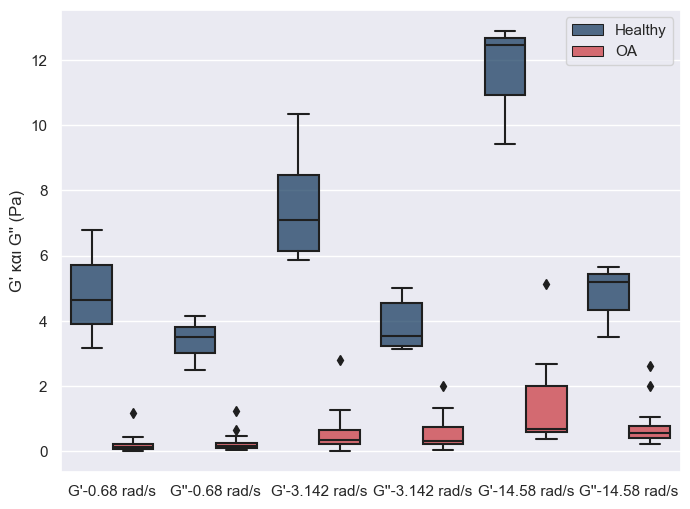

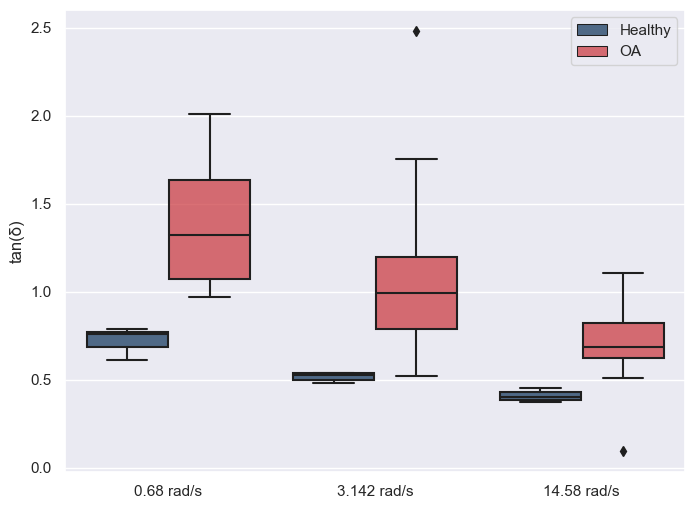

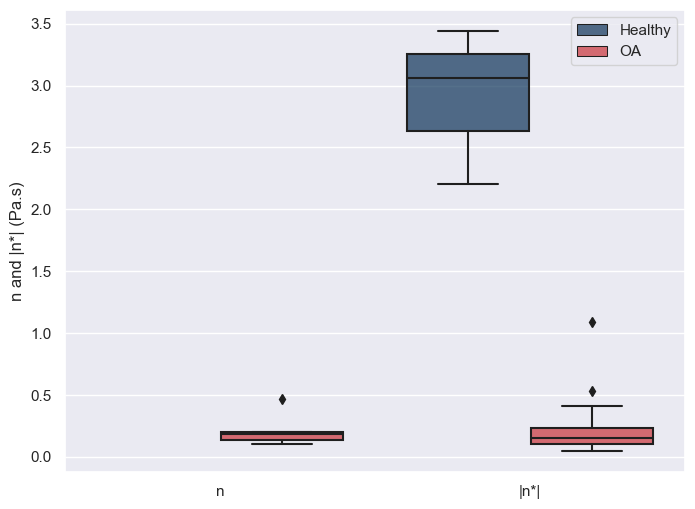

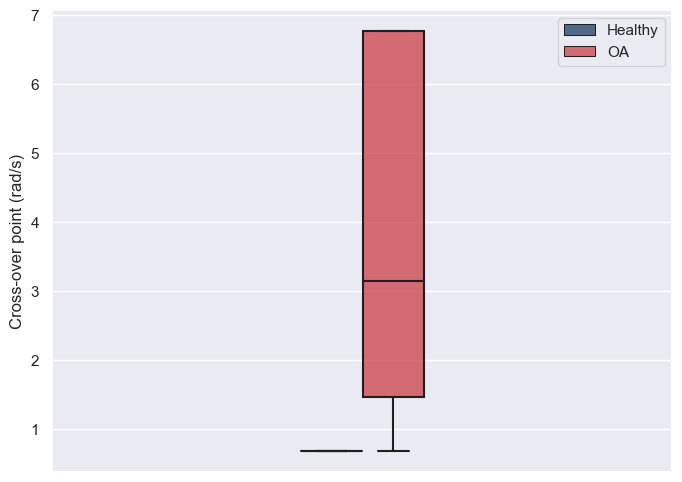

,Frequency Sweep G' at 0.68 rad/s (Pa),Frequency Sweep G'' at 0.68 rad/s (Pa),Time Sweep G' average (Pa),Time Sweep G'' average (Pa),Frequency Sweep G' at 14.58 rad/s (Pa),Frequency Sweep G'' at 14.58 rad/s (Pa),Frequency Sweep Viscosity at 3.142 rad/s (Pa.s),Condition
0,0.130386,0.114700,0.176260,0.162857,0.171502,0.251293,0.106990,1
1,0.665132,0.564575,0.879901,0.638841,1.018357,0.666318,0.520343,0
2,-0.021754,-0.019971,-0.009530,-0.023110,0.180993,0.003173,-0.016116,1
3,0.503938,0.517127,0.805474,0.627362,1.077630,0.666211,0.496844,0
4,-0.223580,-0.269355,-0.413085,-0.339334,-0.400369,-0.280332,-0.230765,1
...,...,...,...,...,...,...,...,...
1999995,0.105365,0.128794,0.194307,0.200929,0.411881,0.296150,0.120603,1
1999996,0.082069,0.075454,0.136831,0.113723,0.086156,0.173240,0.068106,1
1999997,0.720208,0.621950,0.941758,0.706293,1.097267,0.746593,0.576772,0
1999998,-0.023117,0.020964,0.037349,0.074500,0.285582,0.141106,0.019308,1


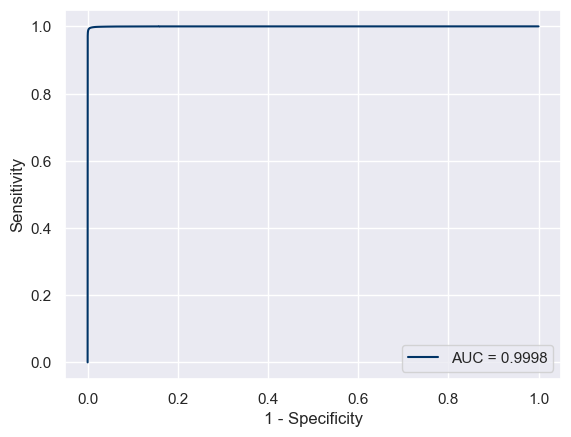

Mean Cross-Validation Accuracy: 0.9951641666666667


In [3]:
# Preprocess data by loading the primary data file "Statistical_Analysis_Database.xlsx"
database = preprocess_data(primary_data_file="Statistical_Analysis_Database.xlsx")

# Filter and clean dataframes based on certain conditions
# Clean data
clean_df = database[(database["Joint"] == "knee") & (database["Blood"] == "no") & (database["Tissue or Clot in Test"] == "no")]
clean_df = clean_df.drop(columns=["Joint", "Blood", "Clot", "Tissue", "Tissue or Clot in Test", 'Storage in freezer', 'COVID 19 now', 'COVID 19', 'Vaccined COVID 19'])

# Create separate dataframes for different conditions
OA_df = database[(database["Joint"] == "knee") & (database["Condition"] == "oa") & (database["Blood"] == "no") & (database["Tissue or Clot in Test"] == "no")]
OA_df = OA_df.drop(columns=["Joint", "Clot", "Tissue", "Tissue or Clot in Test", 'COVID 19 now', 'COVID 19', 'Vaccined COVID 19'])
healthy_df = database[(database["Joint"] == "knee") & (database["Condition"] == "healthy") & (database["Blood"] == "no") & (database["Tissue or Clot in Test"] == "no")]
healthy_df = healthy_df.drop(columns=["Joint", "Clot", "Tissue", "Tissue or Clot in Test", 'COVID 19 now', 'COVID 19', 'Vaccined COVID 19'])

# Combine dataframes
clean_df = pd.concat([healthy_df, OA_df], axis=0, ignore_index=True)

# Further processing of dataframes...
OA_blood_df = database[(database["Joint"] == "knee") & (database["Condition"] == "oa") & (database["Blood"] == "yes") & (database["Tissue or Clot in Test"] == "no")]
OA_blood_df = OA_blood_df.drop(columns=["Joint", "Clot", "Tissue", "Tissue or Clot in Test", 'COVID 19 now', 'COVID 19', 'Vaccined COVID 19'])
OA_total_df = pd.concat([OA_blood_df, OA_df], axis=0, ignore_index=True)
healthy_blood_df = database[(database["Joint"] == "knee") & (database["Condition"] == "healthy") & (database["Blood"] == "yes") & (database["Tissue or Clot in Test"] == "no")]
healthy_blood_df = healthy_blood_df.drop(columns=["Joint", "Clot", "Tissue", "Tissue or Clot in Test", 'COVID 19 now', 'COVID 19', 'Vaccined COVID 19'])
healthy_total_df = pd.concat([healthy_blood_df, healthy_df], axis=0, ignore_index=True)
total_df = pd.concat([healthy_total_df, OA_total_df], axis=0, ignore_index=True)
OA_storage_df = OA_df.copy().reset_index(drop=True)
OA_male_df = OA_df.copy().loc[database["Gender"] == "male"].reset_index(drop=True)
OA_female_df = OA_df.copy().loc[database["Gender"] == "female"].reset_index(drop=True)

# Apply logarithm to specific columns
columns_to_log = [
    "Frequency Sweep G' at 0.68 rad/s (Pa)",
    "Frequency Sweep G'' at 0.68 rad/s (Pa)",
    "Time Sweep G' average (Pa)",
    "Time Sweep G'' average (Pa)",
    "Frequency Sweep G' at 14.58 rad/s (Pa)",
    "Frequency Sweep G'' at 14.58 rad/s (Pa)",
    "Flow Step Viscosity at 3.162 1/s (Pa.s)",
    "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)",
    "Cross Over Point (rad/s)",
    "tan(delta) at 0.68 rad/s",
    "tan(delta) at 3.142 rad/s",
    "tan(delta) at 14.58 rad/s"
]
OA_df_log = apply_logarithm(OA_df.copy(), columns_to_log)
healthy_df_log = apply_logarithm(healthy_df.copy(), columns_to_log)
clean_df_log = pd.concat([healthy_df_log, OA_df_log], axis=0, ignore_index=True)
OA_total_df_log = apply_logarithm(OA_total_df.copy(), columns_to_log)
healthy_total_df_log = apply_logarithm(healthy_total_df.copy(), columns_to_log)
total_df_log = pd.concat([healthy_total_df_log, OA_total_df_log], axis=0, ignore_index=True)
OA_blood_df_log = apply_logarithm(OA_blood_df.copy(), columns_to_log)
OA_storage_df_log = apply_logarithm(OA_storage_df.copy(), columns_to_log)    
OA_male_df_log = apply_logarithm(OA_male_df.copy(), columns_to_log)
OA_female_df_log = apply_logarithm(OA_female_df.copy(), columns_to_log)

# Prepare dataframes for plotting and legend replacement
# Define the value_vars and replacements for each category
value_vars1 = ["Frequency Sweep G' at 0.68 rad/s (Pa)", "Frequency Sweep G'' at 0.68 rad/s (Pa)",
               "Time Sweep G' average (Pa)", "Time Sweep G'' average (Pa)",
               "Frequency Sweep G' at 14.58 rad/s (Pa)", "Frequency Sweep G'' at 14.58 rad/s (Pa)"]
replacements1 = {
    "Frequency Sweep G' at 0.68 rad/s (Pa)": "G' at 0.68 rad/s",
    "Frequency Sweep G'' at 0.68 rad/s (Pa)": "G'' at 0.68 rad/s",
    "Frequency Sweep G' at 14.58 rad/s (Pa)": "G'' at 14.58 rad/s",
    "Frequency Sweep G'' at 14.58 rad/s (Pa)": "G' at 14.58 rad/s",
    "Time Sweep G' average (Pa)": "G' at 3.142 rad/s",
    "Time Sweep G'' average (Pa)": "G'' at 3.142 rad/s"
}
value_vars2 = ["Flow Step Viscosity at 3.162 1/s (Pa.s)", "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)"]
replacements2 = {
    "Flow Step Viscosity at 3.162 1/s (Pa.s)": "n",
    "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)": "|n*|"
}
value_vars3 = ["Cross Over Point (rad/s)"]
replacements3 = {
    "Flow Step Viscosity at 3.162 1/s (Pa.s)": "n",
    "Cross Over Point (rad/s)": "Cross Over Point"
}
value_vars4 = ["tan(delta) at 0.68 rad/s", "tan(delta) at 3.142 rad/s", "tan(delta) at 14.58 rad/s"]
replacements4 = {
    "tan(delta) at 0.68 rad/s": "tan(delta) at 0.68 rad/s",
    "tan(delta) at 3.142 rad/s": "tan(delta) at 3.142 rad/s",
    "tan(delta) at 14.58 rad/s": "tan(delta) at 14.58 rad/s"
}

# Prepare DataFrames for plotting and legend replacement
clean_osc = prepare_dataframe(clean_df, "Condition", value_vars1, replacements1)
clean_n = prepare_dataframe(clean_df, "Condition", value_vars2, replacements2)                                 
clean_cop = prepare_dataframe(clean_df, "Condition", value_vars3, replacements3)
clean_tand = prepare_dataframe(clean_df, "Condition", value_vars4, replacements4)

total_osc = prepare_dataframe(total_df, "Condition", value_vars1, replacements1)
total_n = prepare_dataframe(total_df, "Condition", value_vars2, replacements2)                                  
total_cop = prepare_dataframe(total_df, "Condition", value_vars3, replacements3)
total_tand = prepare_dataframe(total_df, "Condition", value_vars4, replacements4)

OA_total_osc = prepare_dataframe(OA_total_df, "Blood", value_vars1, replacements1)
OA_total_osc = legend_prepare_dataframe(OA_total_osc, "With", "Without")
OA_total_n = prepare_dataframe(OA_total_df, "Blood", value_vars2, replacements2)
OA_total_n = legend_prepare_dataframe(OA_total_n, "With", "Without")
OA_total_cop = prepare_dataframe(OA_total_df, "Blood", value_vars3, replacements3)
OA_total_cop = legend_prepare_dataframe(OA_total_cop, "With", "Without")
OA_total_tand = prepare_dataframe(OA_total_df, "Blood", value_vars4, replacements4)
OA_total_tand = legend_prepare_dataframe(OA_total_tand, "With", "Without")

OA_storage_osc = prepare_dataframe(OA_storage_df, "Storage in freezer", value_vars1, replacements1)
OA_storage_osc = legend_prepare_dataframe(OA_storage_osc, "Frozen", "Not Frozen")
OA_storage_n = prepare_dataframe(OA_storage_df, "Storage in freezer", value_vars2, replacements2)
OA_storage_n = legend_prepare_dataframe(OA_storage_n, "Frozen", "Not Frozen")
OA_storage_cop = prepare_dataframe(OA_storage_df, "Storage in freezer", value_vars3, replacements3)
OA_storage_cop = legend_prepare_dataframe(OA_storage_cop, "Frozen", "Not Frozen")
OA_storage_tand = prepare_dataframe(OA_storage_df, "Storage in freezer", value_vars4, replacements4)
OA_storage_tand = legend_prepare_dataframe(OA_storage_tand, "Frozen", "Not Frozen")

gender_OA_total_osc = prepare_dataframe(OA_total_df, "Gender", value_vars1, replacements1)
gender_OA_total_n = prepare_dataframe(OA_total_df, "Gender", value_vars2, replacements2)
gender_OA_total_cop = prepare_dataframe(OA_total_df, "Gender", value_vars3, replacements3)
gender_OA_total_tand = prepare_dataframe(OA_total_df, "Gender", value_vars4, replacements4)

# Perform t-tests and display results
# Perform t-tests between healthy and OA dataframes
column_names = [
    "Frequency Sweep G' at 0.68 rad/s (Pa)",
    "Frequency Sweep G'' at 0.68 rad/s (Pa)",
    "Time Sweep G' average (Pa)",
    "Time Sweep G'' average (Pa)",
    "Frequency Sweep G' at 14.58 rad/s (Pa)",
    "Frequency Sweep G'' at 14.58 rad/s (Pa)",
    "Flow Step Viscosity at 3.162 1/s (Pa.s)",
    "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)",
    "Cross Over Point (rad/s)",
    "tan(delta) at 0.68 rad/s",
    "tan(delta) at 3.142 rad/s",
    "tan(delta) at 14.58 rad/s"
]

# Perform t-tests and display results
results_df = statistics(healthy_df_log, OA_df_log, column_names)
display(results_df)

# Define biomarker information
biomarkers_info = [
    # Biomarker name, corresponding column, limit, big_var
    ["G' at 0.68 rad/s", "Frequency Sweep G' at 0.68 rad/s (Pa)", 2.18, "control"],
    ["G'' at 0.68 rad/s", "Frequency Sweep G'' at 0.68 rad/s (Pa)", 1.88, "control"],
    ["G' at 3.142 rad/s", "Time Sweep G' average (Pa)", 4.34, "control"],
    ["G'' at 3.142 rad/s", "Time Sweep G'' average (Pa)", 2.58, "control"],
    ["G' at 14.58 rad/s", "Frequency Sweep G' at 14.58 rad/s (Pa)", 7.28, "control"],
    ["G'' at 14.58 rad/s", "Frequency Sweep G'' at 14.58 rad/s (Pa)", 3.06, "control"],
    ["Viscosity |n*| at 3.142 rad/s", "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)", 1.65, "control"],
    ["tan(delta) at 0.68 rad/s", "tan(delta) at 0.68 rad/s", 0.88, "target"],
    ["tan(delta) at 3.142 rad/s", "tan(delta) at 3.142 rad/s", 0.65, "target"],
    ["tan(delta) at 14.58 rad/s", "tan(delta) at 14.58 rad/s", 0.48, "target"]
]
biomarker_df = biomarker_validation(clean_df, biomarkers_info)
display(biomarker_df)

# Call functions to create custom boxplots
# Create custom boxplots for oscillatory data
create_custom_boxplot(clean_osc, "", "G' και G'' (Pa)", ["G'-0.68 rad/s", "G''-0.68 rad/s", "G'-3.142 rad/s", "G''-3.142 rad/s", "G'-14.58 rad/s", "G''-14.58 rad/s"], 
                      hue="Condition", hue_order=['healthy', 'oa'], legend_labels=['Healthy', 'OA'], 
                      width=0.8, dodge=True, yA=0, yB=None)

# Create custom boxplots for tan(delta)
create_custom_boxplot(clean_tand, "", "tan(δ)", ["0.68 rad/s", "3.142 rad/s", "14.58 rad/s"],
                      hue="Condition", hue_order=['healthy', 'oa'], legend_labels=['Healthy', 'OA'], 
                      width=0.8, dodge=True, yA=0, yB=None)

# Create custom boxplots for viscosity
create_custom_boxplot(clean_n, "", "n and |n*| (Pa.s)", ["n", "|n*|"],
                      hue="Condition", hue_order=['healthy', 'oa'], legend_labels=['Healthy', 'OA'], 
                      width=0.8, dodge=True, yA=0, yB=None)

# Create custom boxplots for cross-over point
create_custom_boxplot(clean_cop, "", "Cross-over point (rad/s)", [""],
                      hue="Condition", hue_order=['healthy', 'oa'], legend_labels=['Healthy', 'OA'], 
                      width=0.2, dodge=True, yA=0, yB=None)

# Perform multivariate Monte Carlo Simulation
# Specify the columns to sample
columns_to_sample = ["Frequency Sweep G' at 0.68 rad/s (Pa)",
                     "Frequency Sweep G'' at 0.68 rad/s (Pa)",
                     "Time Sweep G' average (Pa)",
                     "Time Sweep G'' average (Pa)",
                     "Frequency Sweep G' at 14.58 rad/s (Pa)",
                     "Frequency Sweep G'' at 14.58 rad/s (Pa)",
                     "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)"]

# Sample from multivariate normal distribution for healthy_df_log
healthy_artificial_df = multivariate_normal_sampling(healthy_df_log, columns_to_sample, scaled_factor=2)
healthy_artificial_df['Condition'] = 0

# Sample from multivariate normal distribution for OA_df_log
OA_artificial_df = multivariate_normal_sampling(OA_df_log, columns_to_sample, scaled_factor=2)
OA_artificial_df['Condition'] = 1

# Concatenate the sampled DataFrames for both conditions
artificial_df = pd.concat([healthy_artificial_df, OA_artificial_df], axis=0, ignore_index=True)

# Shuffle the rows randomly
artificial_df = artificial_df.reindex(np.random.permutation(artificial_df.index))

# Reset the index of the DataFrame
artificial_df = artificial_df.reset_index(drop=True)

# Display the resulting artificial DataFrame
display(artificial_df)

# Train and evaluate a Logistics Regression model
# Specify the columns to use as predictor variables
columns_to_predict = ["Time Sweep G' average (Pa)",
                      "Time Sweep G'' average (Pa)"]

# Train, evaluate, and perform ROC analysis for the logistic regression model
mean_cross_val_accuracy = logistic_regression(artificial_df, columns_to_predict)

#print("Mean Cross-Validation Accuracy:", mean_cross_val_accuracy)


### More Plotting Options...

In [4]:
"""
# Call the function with different data and labels
create_custom_boxplot(OA_total_osc, "", "G' και G'' (Pa)", ["G'-0.68 rad/s", "G''-0.68 rad/s", "G'-3.142 rad/s", "G''-3.142 rad/s", "G'-14.58 rad/s", "G''-14.58 rad/s"], 
                      hue="Blood", hue_order=['Without', 'With'], legend_labels=['Without blood', 'With blood'],
                      yA=0, yB=3)

create_custom_boxplot(OA_total_tand, "", "tan(δ)", ["0.68 rad/s", "3.142 rad/s", "14.58 rad/s"],
                      hue="Blood", hue_order=['Without', 'With'], legend_labels=['Without blood', 'With blood'])

create_custom_boxplot(OA_total_n, "", "n and |n*| (Pa.s)", ["n", "|n*|"],
                      hue="Blood", hue_order=['Without', 'With'], legend_labels=['Without blood', 'With blood'])

create_custom_boxplot(OA_total_cop, "", "Cross-over point (rad/s)", [""],
                      hue="Blood", hue_order=['Without', 'With'], legend_labels=['Without blood', 'With blood'], width=0.2, dodge=True)



# Call the function with different data and labels
create_custom_boxplot(gender_OA_total_osc, "", "G' και G'' (Pa)", ["G'-0.68 rad/s", "G''-0.68 rad/s", "G'-3.142 rad/s", "G''-3.142 rad/s", "G'-14.58 rad/s", "G''-14.58 rad/s"], 
                      hue="Gender", hue_order=['male', 'female'], legend_labels=['Male', 'Female'],
                      yA=0, yB=3)

create_custom_boxplot(gender_OA_total_tand, "", "tan(δ)", ["0.68 rad/s", "3.142 rad/s", "14.58 rad/s"],
                      hue="Gender", hue_order=['male', 'female'], legend_labels=['Male', 'Female'])

create_custom_boxplot(gender_OA_total_n, "", "n and |n*| (Pa.s)", ["n", "|n*|"],
                      hue="Gender", hue_order=['male', 'female'], legend_labels=['Male', 'Female'])

create_custom_boxplot(gender_OA_total_cop, "", "Cross-over point (rad/s)", [""],
                      hue="Gender", hue_order=['male', 'female'], legend_labels=['Male', 'Female'], width=0.2, dodge=True)



# Create first database
file_name = "Database.xlsx"
column_labels = ['ID', 'Date', 'Gender', 'Age', 'Joint', 'Condition', 'Total Volume (mL)', 'Color', 
                     'Transparency', 'Texture', 'Blood', 'Clot', 'Tissue', 'Storage in freezer', 'COVID 19', 
                     'Vaccinated COVID 19', 'COVID 19 now', 'Number of Tests', 'Test Type', 
                     'Temperature (oC)', 'Tissue in Test', 'Bubbles before Test', 'Bubbles after Test']
create_database(file_name, column_labels)

# Create final database
file_name2 = "Statistical_Analysis_Database.xlsx"    
column_labels2 = ["ID", "Gender", "Age", "Joint", "Condition", "Blood", "Clot", "Tissue", 
                     "Tissue or Clot in Test", "Storage in freezer", "COVID 19", 
                     "Vaccined COVID 19", "COVID 19 now", "Time Sweep G' average (Pa)", 
                     "Time Sweep G'' average (Pa)", "Time Sweep G' standard deviation (-)", 
                     "Time Sweep G'' standard deviation (-)", "Frequency Sweep G' at 0.68 rad/s (Pa)", 
                     "Frequency Sweep G'' at 0.68 rad/s (Pa)", "Frequency Sweep G' at 3.142 rad/s (Pa)", 
                     "Frequency Sweep G'' at 3.142 rad/s (Pa)", "Frequency Sweep G' at 14.58 rad/s (Pa)", 
                     "Frequency Sweep G'' at 14.58 rad/s (Pa)", "Cross Over Point (rad/s)", 
                     "Frequency Sweep Viscosity at 3.142 rad/s (Pa.s)", 
                     "Zero-rate Viscosity (Pa.s)", "Infinite-rate Viscosity (Pa.s)", "Consistency (s)", 
                     "Rate Index (-)", "Standard Error (-)", "Flow Step Viscosity at 3.162 1/s (Pa.s)"]
create_database(file_name2, column_labels2)
"""

'\n# Call the function with different data and labels\ncreate_custom_boxplot(OA_total_osc, "", "G\' και G\'\' (Pa)", ["G\'-0.68 rad/s", "G\'\'-0.68 rad/s", "G\'-3.142 rad/s", "G\'\'-3.142 rad/s", "G\'-14.58 rad/s", "G\'\'-14.58 rad/s"], \n                      hue="Blood", hue_order=[\'Without\', \'With\'], legend_labels=[\'Without blood\', \'With blood\'],\n                      yA=0, yB=3)\n\ncreate_custom_boxplot(OA_total_tand, "", "tan(δ)", ["0.68 rad/s", "3.142 rad/s", "14.58 rad/s"],\n                      hue="Blood", hue_order=[\'Without\', \'With\'], legend_labels=[\'Without blood\', \'With blood\'])\n\ncreate_custom_boxplot(OA_total_n, "", "n and |n*| (Pa.s)", ["n", "|n*|"],\n                      hue="Blood", hue_order=[\'Without\', \'With\'], legend_labels=[\'Without blood\', \'With blood\'])\n\ncreate_custom_boxplot(OA_total_cop, "", "Cross-over point (rad/s)", [""],\n                      hue="Blood", hue_order=[\'Without\', \'With\'], legend_labels=[\'Without blood\', \'